## Potential Talents - Part 3

----

### Objectives:

Retrieve the most similar job titles to a query using several embedding families, and compare their rankings.

### Summary:

   0) Setup & Data
   1) Load custom SGNS embeddings (from Part 2, mini-Word2Vec)
   2) Tokenization for titles (keep it simple & consistent)
   3) Custom mini-Word2Vec (my SGNS from part 2)
   4) Word2Vec (Google)
   5) GloVe (Stanford)
   6) FastText (Meta)
   7) BERT (Google; mean/CLS pooling)
   8) Sentece-BERT (SBERT; sentence-level embeddings)
   9) Ranking & side-by-side comparison (qualitative / quantitative)
  

----


## 0. Setup & Data

In [1]:
import os, math, random
import numpy as np
import pandas as pd
import torch
from torch import nn
import sys

In [2]:
print("python:", sys.executable)
print("torch file:", torch.__file__)
print("torch version:", torch.__version__)
print("torch.version.cuda:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())

python: e:\Devs\pyEnv-1\venvs\Pot-Tals_3_env\Scripts\python.exe
torch file: e:\Devs\pyEnv-1\venvs\Pot-Tals_3_env\Lib\site-packages\torch\__init__.py
torch version: 2.6.0+cu124
torch.version.cuda: 12.4
cuda available: True


In [3]:
SEED = 23
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [4]:
df = pd.read_csv("./data/potential_talents.csv")
titles = df["job_title"].astype(str).tolist()
len(titles), titles[:5]


(104,
 ['2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional',
  'Native English Teacher at EPIK (English Program in Korea)',
  'Aspiring Human Resources Professional',
  'People Development Coordinator at Ryan',
  'Advisory Board Member at Celal Bayar University'])

## 1. Custom SGNS embeddings (from Part 2, mini-Word2Vec)

In [5]:
# Load SGNS checkpoint (from Part 2)
ckpt_path = "checkpoints/sgns_text8.pt"
ckpt = torch.load(ckpt_path, map_location="cpu")


In [6]:
ckpt.keys()

dict_keys(['model_state', 'itos', 'config'])

In [7]:
ckpt['config'] 

{'embed_dim': 300}

In [8]:
ckpt['itos'][:10] 

['a', 'aa', 'aaa', 'aaaa', 'aaai', 'aaas', 'aac', 'aachen', 'aafc', 'aage']

In [9]:
print(type(ckpt['model_state']))
print(ckpt['model_state'].keys())

<class 'collections.OrderedDict'>
odict_keys(['emb_in.weight', 'emb_out.weight'])


In [10]:
itos = ckpt["itos"]
stoi = {w:i for i,w in enumerate(itos)}

E_in  = ckpt["model_state"]["emb_in.weight"].detach().float()   # [|V|, D]
E_out = ckpt["model_state"]["emb_out.weight"].detach().float()  # [|V|, D]

# as in Part2, use the avg 
E_comb = 0.5 * (E_in + E_out)
E_comb = E_comb / (E_comb.norm(dim=1, keepdim=True) + 1e-12)

E_comb.shape


torch.Size([71290, 300])

## 2) Tokenization for titles (keep it simple & consistent)

In [11]:
import re, unicodedata
import nltk
_ = nltk.download('punkt', quiet=True)

In [12]:
# regex for separator chars to normalize/split title delimiters
SEP_RE = re.compile(r"[|/\\•·–—\-]+")      

def canonicalize_title(s: str, strip_org_tail: bool = True) -> str:
    """
    Light canonicalization (cleaning) that preserves full sentence content:
    - Unicode NFKC normalization, trim, lowercase
    - Normalize separators (& -> 'and')
    - Collapse whitespace
    Input: string → Output: cleaned string.
    """
    
    # if the input isn’t a string, return an empty string
    if not isinstance(s, str): 
        return ""
    
    # Unicode normalization form NFKC + strip + lowercase
    s = unicodedata.normalize("NFKC", s).strip().lower()
    s = SEP_RE.sub(" ", s)                 # “hr manager | engie” -> “hr manager  engie”
    s = s.replace("&", " and ")
        
    # collapses any run of whitespace (spaces, tabs) to a single space
    s = re.sub(r"\s+", " ", s)
    
    return s

In [13]:
# Simple, stable regex tokenizer: keep a–z sequences (no stopword/org stripping)
TOKEN_RE = re.compile(r"[a-z]+")

def tokenize_title(s: str, drop_org_like=True) -> list[str]:
    """
    Canonicalize, then regex-tokenize. No stopword/org filtering.
    Input: string → Output: list of tokens.
    """ 
    s = canonicalize_title(s)
    # every sequence of [a-z]+ becomes one token
    toks = TOKEN_RE.findall(s)
    
    return toks

In [14]:
# Build shared columns (used by ALL embedding families)
df["title_text"] = df["job_title"].apply(canonicalize_title)   # full sentence, orgs kept
df["tokens"]     = df["title_text"].apply(tokenize_title)      # tokens, same for every embedding family

# Peek
df[["job_title", "title_text", "tokens"]].head(10)


,job_title,title_text,tokens
0,2019 C.T. Bauer College of Business Graduate (...,2019 c.t. bauer college of business graduate (...,"[c, t, bauer, college, of, business, graduate,..."
1,Native English Teacher at EPIK (English Progra...,native english teacher at epik (english progra...,"[native, english, teacher, at, epik, english, ..."
2,Aspiring Human Resources Professional,aspiring human resources professional,"[aspiring, human, resources, professional]"
3,People Development Coordinator at Ryan,people development coordinator at ryan,"[people, development, coordinator, at, ryan]"
4,Advisory Board Member at Celal Bayar University,advisory board member at celal bayar university,"[advisory, board, member, at, celal, bayar, un..."
5,Aspiring Human Resources Specialist,aspiring human resources specialist,"[aspiring, human, resources, specialist]"
6,Student at Humber College and Aspiring Human R...,student at humber college and aspiring human r...,"[student, at, humber, college, and, aspiring, ..."
7,HR Senior Specialist,hr senior specialist,"[hr, senior, specialist]"
8,Student at Humber College and Aspiring Human R...,student at humber college and aspiring human r...,"[student, at, humber, college, and, aspiring, ..."
9,Seeking Human Resources HRIS and Generalist Po...,seeking human resources hris and generalist po...,"[seeking, human, resources, hris, and, general..."


## 3) Custom mini-Word2Vec: 

This implementation follows **Skip-Gram with Negative Sampling** in PyTorch with two embedding tables: $E_{\text{in}}$ (centers) and $E_{\text{out}}$ (contexts). For each (center, positive) pair, it samples $K$ negatives and optimizes the SGNS objective above. To form final word vectors, it uses the **average** of the two tables,
$$
E_{\text{comb}}=\tfrac{1}{2}\big(E_{\text{in}}+E_{\text{out}}\big),
$$
then encodes a title by averaging its in-vocab word vectors and searches via **cosine similarity**. This keeps training and inference lightweight while capturing useful semantic structure.

### 3.1) Encode a title as the mean of its word vectorsb

In [15]:
E = E_comb

@torch.no_grad()
def encode_tokens_mean(tokens: list[str], E: torch.Tensor, stoi: dict) -> torch.Tensor | None:
    idxs = [stoi[t] for t in tokens if t in stoi]
    if not idxs:
        return None
    v = E[idxs].mean(dim=0)                 # [D]
    return v / (v.norm() + 1e-12)

@torch.no_grad()
def encode_title_mean(text: str, E: torch.Tensor, stoi: dict) -> torch.Tensor | None:
    return encode_tokens_mean(tokenize_title(text), E, stoi)

In [16]:
# Rebuild title matrix using df["tokens"] (shared preprocessing)
vecs, keep_idx = [], []
for i, toks in enumerate(df["tokens"]):
    v = encode_tokens_mean(toks, E, stoi)
    if v is not None:
        vecs.append(v); keep_idx.append(i)

X_sgns_mean = torch.stack(vecs)  # [N_kept, D], rows are L2-normalized
print("encoded titles:", X_sgns_mean.shape, "kept rows:", len(keep_idx), "of", len(df))


encoded titles: torch.Size([104, 300]) kept rows: 104 of 104


In [17]:
X_sgns_mean[0] 

tensor([ 0.0102, -0.0397,  0.0605, -0.0698, -0.0451, -0.0469,  0.0385, -0.0740,
         0.0400, -0.0557, -0.0359,  0.0659,  0.0657, -0.0421, -0.0308,  0.0900,
         0.0729,  0.0266,  0.0625, -0.0746,  0.0684, -0.0777, -0.0475, -0.0569,
        -0.0385, -0.0662,  0.0363, -0.0352,  0.0336, -0.0520, -0.0362, -0.0415,
        -0.0313, -0.0825,  0.0237, -0.0868,  0.0350, -0.0584, -0.0503, -0.0151,
        -0.0609,  0.0724, -0.0663, -0.0268,  0.0566, -0.0289, -0.0805,  0.0526,
         0.0408, -0.0282,  0.0904,  0.0533, -0.0580, -0.0389,  0.0214,  0.0406,
         0.0169, -0.0786,  0.0762,  0.0449,  0.0346,  0.0671, -0.1035,  0.0652,
         0.0573, -0.0475, -0.0698,  0.0104,  0.0614, -0.0513,  0.0431, -0.0888,
        -0.0016,  0.0719,  0.0592,  0.0448,  0.0400,  0.0439,  0.0604, -0.0345,
         0.0523, -0.0517, -0.0570, -0.0236,  0.0325, -0.0366, -0.0302, -0.0621,
        -0.0702, -0.0622, -0.0323, -0.0287,  0.0569,  0.0271,  0.0420,  0.0780,
        -0.0658,  0.0758,  0.0521,  0.04

In [18]:
import matplotlib.pyplot as plt

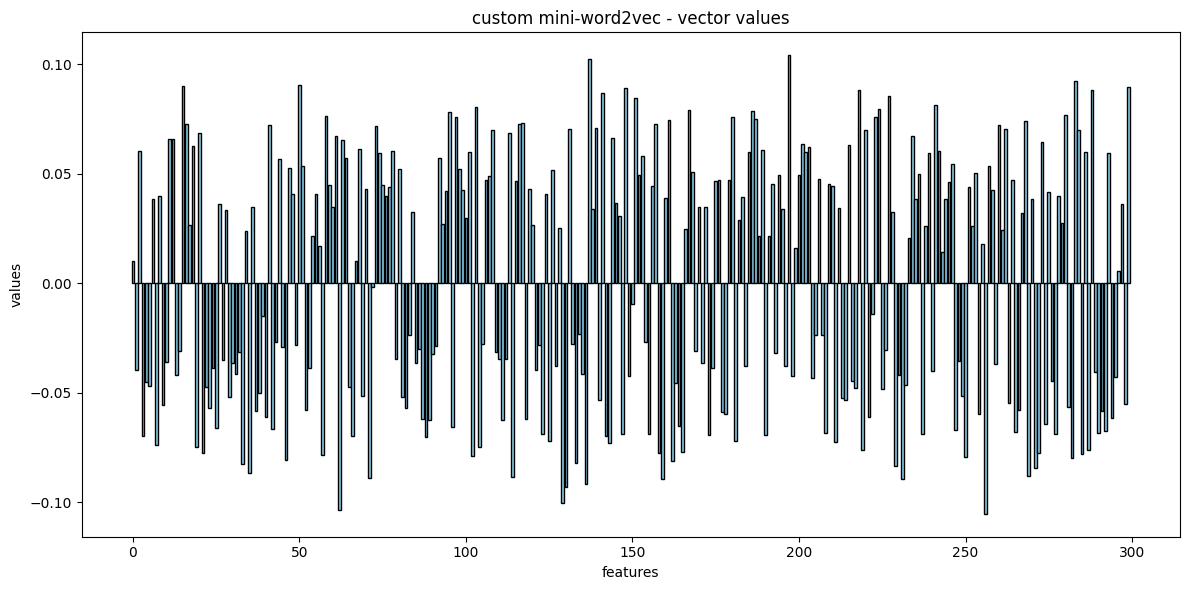

In [19]:
plt.figure(figsize=(12, 6))
plt.bar(range(300), X_sgns_mean[0], color='skyblue', edgecolor='black')
plt.title("custom mini-word2vec - vector values")
plt.xlabel("features")
plt.ylabel("values")
plt.tight_layout()
plt.show()

### 3.2) Cosine search over titles (dot product of normalized vectors)

Cosine search over titles: one function we can reuse for SGNS(mini-Word2Vec)/GloVe/FastText by swapping E, stoi, X, keep_idx.

In [20]:
# search using cosine similarity
@torch.no_grad()
def search_titles(query: str,
                  X: torch.Tensor,
                  E: torch.Tensor,
                  stoi: dict,
                  keep_idx: list[int],
                  df: pd.DataFrame,
                  topk: int = 10,
                  dedupe: bool = True):
    
    # encode query with the SAME tokenizer
    q_tokens = tokenize_title(query)
    q = encode_tokens_mean(q_tokens, E, stoi)
    if q is None:
        return [], "Query has no in-vocab tokens."

    sims = (X @ q)                                      # cosine = dot (rows normalized)
    top = torch.topk(sims, k=min(topk*3, sims.numel())) # oversample if deduping

    rows = []
    seen = set()
    for idx in top.indices.tolist():
        row_id = keep_idx[idx]
        title_str = df.loc[row_id, "job_title"]            # <-- key used for dedupe
        if dedupe:
            if title_str in seen:                          # <-- duplicates dropped
                continue
            seen.add(title_str)
        rows.append((title_str, float(sims[idx].item())))
        if len(rows) == topk:
            break
    return rows, None




In [21]:
# quick test
for q in ["data scientist", "machine learning engineer", "backend developer", "product manager"]:
    res, err = search_titles(q, X_sgns_mean, E, stoi, keep_idx, df, topk=10, dedupe=True)
    print(f"\nQuery: {q}")
    if err: print("  ", err)
    else:
        for t, s in res:
            print(f"  {s: .3f}  {t}")



Query: data scientist
   0.793  Information Systems Specialist and Programmer with a love for data and organization.
   0.748  Junior MES Engineer| Information Systems
   0.731  SVP, CHRO, Marketing & Communications, CSR Officer | ENGIE | Houston | The Woodlands | Energy | GPHR | SPHR
   0.729  Human Resources professional for the world leader in GIS software
   0.727  Business Intelligence and Analytics at Travelers
   0.714  Aspiring Human Resources Manager | Graduating May 2020 | Seeking an Entry-Level Human Resources Position in St. Louis
   0.706  Undergraduate Research Assistant at Styczynski Lab
   0.706  Student at Indiana University Kokomo - Business Management - 
Retail Manager at Delphi Hardware and Paint
   0.702  2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional
   0.701  Business Management Major and Aspiring Human Resources Manager

Query: machine learning engineer
   0.825  Junior MES Engineer| Information Systems


## 4) Experiment with the GoogleNews Word2Vec vectors (Google, 2013)

Word2Vec learns dense vectors so that words sharing contexts have nearby embeddings. In the **skip-gram** view, for a center word $w_t$ it predicts surrounding words $w_{t+j}$. Training usually uses **negative sampling** to replace the full softmax with a small binary task per pair. The classic per-example objective is
$$
\log \sigma(u_{w_t}^\top v_{w_{t+j}})\;+\;\sum_{k=1}^{K}\log \sigma\!\left(-\,u_{w_t}^\top v_{n_k}\right),
$$
where $u$ is the input (center) embedding, $v$ the output (context) embedding, and $n_k$ are sampled “negative” words. The GoogleNews model provides pretrained 300-d vectors trained on a very large corpus.


A) Using Gensim’s downloader (auto-download, ~1.6GB):

In [22]:
from gensim.models import KeyedVectors


In [23]:
W2V_PATH = r"./data/GoogleNews-vectors-negative300.bin"

In [24]:
# Load the binary GoogleNews KeyedVectors
w2v = KeyedVectors.load_word2vec_format(W2V_PATH, binary=True)
print("w2v vocab:", len(w2v), "dim:", w2v.vector_size)

w2v vocab: 3000000 dim: 300


### 4.1) Encode tokens

Keep the same functions (encode_tokens_mean, encode_title_mean, search_titles) and the same flow.

In [28]:
# 1) Collect the words we actually need from the dataset
needed = sorted({t for toks in df["tokens"] for t in toks if t in w2v.key_to_index})
needed_not_in_w2v = sorted({t for toks in df["tokens"] for t in toks if t not in w2v.key_to_index})
print("needed tokens in w2v:", len(needed))

needed tokens in w2v: 174


In [42]:
# 2) Build stoi and E (normalized rows) for just those words
stoi_w2v = w2v.key_to_index
E_w2v = torch.from_numpy(w2v.vectors)              # shares memory
E_w2v = E_w2v / (E_w2v.norm(dim=1, keepdim=True)+1e-12)



In [43]:
# E_w2v (torch) + stoi_w2v (dict) match the previous SGNS interface
print(E_w2v.shape, len(stoi_w2v))

torch.Size([3000000, 300]) 3000000


Encode tokens per title and then calculate the mean value for the title embeddings.

In [40]:
vecs_w2v, keep_idx_w2v = [], []
for i, toks in enumerate(df["tokens"]):
    v = encode_tokens_mean(toks, E_w2v, stoi_w2v) 
    if v is not None:
        vecs_w2v.append(v); keep_idx_w2v.append(i)

X_w2v_mean = torch.stack(vecs_w2v)   # rows already normalized
print("w2v encoded titles:", X_w2v_mean.shape)


w2v encoded titles: torch.Size([104, 300])


In [41]:
# quick test
for q in ["data scientist", "machine learning engineer", "backend developer", "product manager"]:
    res, err = search_titles(q, X_w2v_mean, E_w2v, stoi_w2v, keep_idx_w2v, df, topk=10, dedupe=True)
    print(f"\nQuery: {q}")
    if err: print("  ", err)
    else:
        for t, s in res:
            print(f"  {s: .3f}  {t}")
            


Query: data scientist
   0.516  Information Systems Specialist and Programmer with a love for data and organization.
   0.450  Undergraduate Research Assistant at Styczynski Lab
   0.447  Junior MES Engineer| Information Systems
   0.346  Human Resources Specialist at Luxottica
   0.340  Business Intelligence and Analytics at Travelers
   0.328  Aspiring Human Resources Specialist
   0.318  Liberal Arts Major. Aspiring Human Resources Analyst.
   0.314  Senior Human Resources Business Partner at Heil Environmental
   0.313  SVP, CHRO, Marketing & Communications, CSR Officer | ENGIE | Houston | The Woodlands | Energy | GPHR | SPHR
   0.305  Bachelor of Science in Biology from Victoria University of Wellington

Query: machine learning engineer
   0.524  Junior MES Engineer| Information Systems
   0.492  Information Systems Specialist and Programmer with a love for data and organization.
   0.393  Aspiring Human Resources Professional | Passionate about helping to create an inclusive and

## 5) Experiment with the GloVE vectors (Stanford, 2014)

GloVe is a **global co-occurrence** method: it builds a word–word co-occurrence matrix $X_{ij}$ from a large corpus and learns embeddings by regressing the **log counts**. The weighted least-squares loss is
$$
J=\sum_{i,j} f(X_{ij})\Big(u_i^\top v_j + b_i + \tilde b_j - \log X_{ij}\Big)^2,
$$
where $f(\cdot)$ down-weights rare and extremely frequent pairs. This blends global matrix-factorization flavor (like SVD) with the efficiency of local windowing, producing robust, widely used embeddings.



#### 5.1) Collect the words we actually need (from the job titles)

In [47]:
# Words actually appearing in your dataset tokens (all lowercased already)
needed_glove = sorted({t for toks in df["tokens"] for t in toks})
len(needed_glove)


199

In [48]:
GLOVE_DIR = "./data/"
GLOVE_TXT = os.path.join(GLOVE_DIR, "glove.6B.300d.txt")

In [49]:
vecs_glove_map = {}
dim_glove = None

with open(GLOVE_TXT, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.rstrip().split(" ")
        w = parts[0]
        if w in needed_glove:
            v = np.asarray(parts[1:], dtype=np.float32)
            if dim_glove is None:
                dim_glove = v.size
            vecs_glove_map[w] = v

print("loaded words:", len(vecs_glove_map), "dim:", dim_glove)

loaded words: 191 dim: 300


#### 5.2) Build `stoi_glove` and `E_glove` (row-normalized)

In [50]:
words_glove = sorted(vecs_glove_map.keys())
stoi_glove = {w: i for i, w in enumerate(words_glove)}

E_glove = torch.from_numpy(np.stack([vecs_glove_map[w] for w in words_glove])).float()
E_glove = E_glove / (E_glove.norm(dim=1, keepdim=True) + 1e-12)

print(E_glove.shape, len(stoi_glove))


torch.Size([191, 300]) 191


#### 5.3) Encode titles (mean of word vectors)

In [51]:
vecs_glove, keep_idx_glove = [], []
for i, toks in enumerate(df["tokens"]):
    v = encode_tokens_mean(toks, E_glove, stoi_glove)
    if v is not None:
        vecs_glove.append(v); keep_idx_glove.append(i)

X_glove_mean = torch.stack(vecs_glove)   # rows already normalized
print("glove encoded titles:", X_glove_mean.shape, "kept:", len(keep_idx_glove))

glove encoded titles: torch.Size([104, 300]) kept: 104


#### 5.4) Quick test

In [52]:
for q in ["data scientist", "machine learning engineer", "backend developer", "product manager"]:
    rows, err = search_titles(q, X_glove_mean, E_glove, stoi_glove, keep_idx_glove, df, topk=10, dedupe=True)
    print(f"\nQuery: {q}")
    if err: 
        print("  ", err)
    else:
        for t, s in rows:
            print(f"  {s: .3f}  {t}")


Query: data scientist
   0.579  Information Systems Specialist and Programmer with a love for data and organization.
   0.506  Seeking employment opportunities within Customer Service or Patient Care
   0.478  Junior MES Engineer| Information Systems
   0.477  Human Resources professional for the world leader in GIS software
   0.470  Business Intelligence and Analytics at Travelers
   0.460  Nortia Staffing is seeking Human Resources, Payroll & Administrative Professionals!!  (408) 709-2621
   0.455  Human Resources|
Conflict Management|
Policies & Procedures|Talent Management|Benefits & Compensation
   0.451  Human Resources Management Major
   0.427  Business Management Major and Aspiring Human Resources Manager
   0.420  Aspiring Human Resources Manager | Graduating May 2020 | Seeking an Entry-Level Human Resources Position in St. Louis

Query: machine learning engineer
   0.586  Junior MES Engineer| Information Systems
   0.382  Retired Army National Guard Recruiter, office manag

## 6) Experiment with fastText (Meta, 2016)

FastText extends Word2Vec with **subword (character n-gram) embeddings**. A word’s vector is the sum of its n-gram vectors, which gives:
- robust representations for rare words, and
- the ability to **synthesize vectors for OOV words** (e.g., typos, inflections).

We’ll load pre-trained English FastText vectors and use the same pipeline as before:
tokenize → average word vectors per title → cosine search.


#### 6.1) Load & encode

In [56]:
from gensim.models.fasttext import load_facebook_vectors

In [57]:
# Facebook binary with subword support
FASTTEXT_PATH = r"./data/cc.en.300.bin"
ft = load_facebook_vectors(FASTTEXT_PATH)

print("fastText vocab (known):", len(ft), "dim:", ft.vector_size)

fastText vocab (known): 2000000 dim: 300


In [58]:
# Build stoi/E for just the tokens in our dataset (keeps memory down)
needed_ft = sorted({t for toks in df["tokens"] for t in toks})
stoi_ft = {w: i for i, w in enumerate(needed_ft)}

E_ft = torch.from_numpy(
    np.stack([ft.get_vector(w) for w in needed_ft]).astype(np.float32)
)
E_ft = E_ft / (E_ft.norm(dim=1, keepdim=True) + 1e-12)
print("E_ft:", E_ft.shape, "stoi_ft:", len(stoi_ft))


E_ft: torch.Size([199, 300]) stoi_ft: 199


In [59]:
# Encode titles (mean of word vectors), same helper as before
vecs_ft, keep_idx_ft = [], []
for i, toks in enumerate(df["tokens"]):
    v = encode_tokens_mean(toks, E_ft, stoi_ft)
    if v is not None:
        vecs_ft.append(v); keep_idx_ft.append(i)

X_ft_mean = torch.stack(vecs_ft)  # rows normalized already
print("fastText encoded titles:", X_ft_mean.shape, "kept:", len(keep_idx_ft))

fastText encoded titles: torch.Size([104, 300]) kept: 104


In [60]:
for q in ["data scientist", "machine learning engineer", "backend developer", "product manager"]:
    rows, err = search_titles(q, X_ft_mean, E_ft, stoi_ft, keep_idx_ft, df, topk=10, dedupe=True)
    print(f"\nQuery: {q}")
    if err:
        print("  ", err)
    else:
        for t, s in rows:
            print(f"  {s: .3f}  {t}")


Query: data scientist
   0.475  Information Systems Specialist and Programmer with a love for data and organization.
   0.436  Junior MES Engineer| Information Systems
   0.413  Business Intelligence and Analytics at Travelers
   0.386  Human Resources|
Conflict Management|
Policies & Procedures|Talent Management|Benefits & Compensation
   0.351  Human Resources Management Major
   0.351  Nortia Staffing is seeking Human Resources, Payroll & Administrative Professionals!!  (408) 709-2621
   0.337  SVP, CHRO, Marketing & Communications, CSR Officer | ENGIE | Houston | The Woodlands | Energy | GPHR | SPHR
   0.333  Seeking employment opportunities within Customer Service or Patient Care
   0.327  Human Resources professional for the world leader in GIS software
   0.313  Business Management Major and Aspiring Human Resources Manager

Query: machine learning engineer
   0.606  Junior MES Engineer| Information Systems
   0.453  HR Senior Specialist
   0.422  Retired Army National Guard Re

## 7) Experiment with BERT (Google, 2018)

In [62]:
from transformers import AutoTokenizer, AutoModel

In [67]:
BERT_NAME = "bert-base-uncased"
tok_bert  = AutoTokenizer.from_pretrained(BERT_NAME)
mdl_bert  = AutoModel.from_pretrained(BERT_NAME).to(device).eval()

#### Why no “embeddings file” like GloVe/word2vec/fastText?

**Static vs contextual**. GloVe/word2vec/fastText ship a static matrix: one vector per token, stored in a big text/bin file you load directly.

**BERT is a full neural model**. It still has an embedding table inside (token + position + segment embeddings), but its outputs are contextual, The vector for “bank” changes with the sentence. So you don’t download a plain .txt of vectors, we download the entire model weights (a .bin file via Hugging Face) and then run the model to get embeddings for a sentence or token sequence.

In [66]:
# token embedding table (WordPiece-level), shape [vocab_size, hidden_size]
E_bert = mdl_bert.get_input_embeddings().weight.detach().cpu()
print(E_bert.shape)

torch.Size([30522, 768])


…but this is subword-level (WordPiece like “##ing”, “bank”, “[UNK]”), and using it as static word vectors misses BERT’s main advantage:  **contextualization**.

#### 7.1) Mean/CLS pooling helpers

**Goal:** turn a sequence of token embeddings from BERT into a single fixed-size vector for similarity/search.

---

#### Mean Pooling (masked average)
Compute the average of the last-layer token embeddings, ignoring padding:
$$
\mathbf{e}_{\text{mean}}
=\frac{1}{\sum_t m_t}\sum_{t=1}^{T} m_t\,\mathbf{h}_t,
$$
where $\mathbf{h}_t\in\mathbb{R}^H$ is the hidden state at token $t$ and $m_t\in\{0,1\}$ is the attention mask (1 = real token).

**Pros**
- Uses **all** tokens; robust for short, noisy text.
- Stable without fine-tuning; common for retrieval with base BERT.

**Cons**
- Can **dilute** key words (generic terms dominate if not IDF-weighted).
- Treats all tokens equally unless we add weights.


---

#### `[CLS]` Pooling (use the first token)
Take the hidden state at the special `[CLS]` position:
$$
\mathbf{e}_{\text{CLS}}=\mathbf{h}_{\text{[CLS]}}.
$$

**Pros**
- Often **sharper** for short texts; designed as a sequence-level summary in many fine-tuned classifiers.
- Single vector without averaging.

**Cons**
- In **base** BERT (no fine-tuning), `[CLS]` is **not** optimized for similarity; may be less reliable than mean for retrieval.
- Sensitive to model fine-tuning objectives.

In [77]:
from torch.nn.functional import normalize

In [83]:
USE_CLS = False  # set True to use [CLS] pooling instead of mean

@torch.no_grad()
def encode_bert_batch(texts, pooling='mean', normalize=True):
    """
    texts: list[str] -> tensor [B, H] (L2-normalized)
    """
    enc = tok_bert(
        list(texts), 
        padding=True, 
        truncation=True, 
        max_length=max_length, 
        return_tensors="pt"
    ).to(device)
    out = mdl_bert(**enc)  # last_hidden_state: [B, T, H]
    H = out.last_hidden_state
    
    if pooling == "mean":
        mask = enc["attention_mask"].unsqueeze(-1)   # [B, T, 1]
        v = (H * mask).sum(dim=1) / mask.sum(dim=1).clamp_min(1e-123)
    elif pooling == "cls":
        v = H[:,0,:]  # first token CLS
    else:
        raise ValueError("pooling must be 'mean' or 'cls'")
    
    if normalize:
        v = v / (v.norm(dim=1, keepdim=True) + 1e-12)
    return v
    


#### 7.2) Build title embeddings (batched)

In [87]:
X_bert = torch.cat([
    encode_bert_batch(df['title_text'].iloc[i:i+64],
    pooling="mean",
    normalize=True) for i in range(0, len(df), 64)], dim=0)
    
keep_idx_bert = list(range(len(df)))                   # 1:1 rows with df
print("BERT encoded titles:", X_bert.shape, "kept:", len(keep_idx_bert))

NameError: name 'max_length' is not defined

#### 7.3) Cosine search over titles with BERT

In [88]:
@torch.no_grad()
def search_titles_bert(query: str,
                       X: torch.Tensor,
                       df: pd.DataFrame,
                       topk: int = 10,
                       dedupe: bool = True):
    q = encode_bert_batch(
        [canonicalize_title(query)],
        pooling="mean",
        normalize=True)  # [1, H]
    sims = (X @ q[0])                                    # [N]
    top = torch.topk(sims, k=min(topk*3, sims.numel()))  # oversample if deduping

    rows, seen = [], set()
    for idx in top.indices.tolist():
        title_str = df.loc[idx, "job_title"]
        if dedupe and title_str in seen:
            continue
        seen.add(title_str)
        rows.append((title_str, float(sims[idx].item())))
        if len(rows) == topk:
            break
    return rows, None

In [89]:
# quick test (same queries as other families)
for q in ["data scientist", "machine learning engineer", "backend developer", "product manager"]:
    rows, err = search_titles_bert(q, X_bert, df, topk=10, dedupe=True)
    print(f"\nQuery: {q}")
    if err: 
        print("  ", err)
    else:
        for t, s in rows:
            print(f"  {s: .3f}  {t}")

NameError: name 'max_length' is not defined

Collecting results for later comparison:

In [44]:
# Embedding Families and the results
FAMILIES = {
    "SGNS": (X_sgns_mean, E_comb, stoi,      keep_idx),
    "W2V" : (X_w2v_mean,  E_w2v,  stoi_w2v,  keep_idx_w2v),
    }

queries = ["data scientist", "machine learning engineer", "backend developer", "product manager"]
K = 10

# Store top-k *titles* (strings) for each family & query
results_topk = {fam: {} for fam in FAMILIES}

for fam, (X, E, stoi_f, keep_idx_f) in FAMILIES.items():
    for q in queries:
        rows, err = search_titles(q, X, E, stoi_f, keep_idx_f, df, topk=K, dedupe=True)
        results_topk[fam][q] = [title for (title, _score) in rows] if not err else []

print("Stored top-k results in results_topk[family][query].")

Stored top-k results in results_topk[family][query].


In [45]:
def overlap_at_k(list_a, list_b, k=10):
    A, B = set(list_a[:k]), set(list_b[:k])
    denom = max(1, min(k, len(A), len(B)))
    return len(A & B) / denom

def jaccard_at_k(list_a, list_b, k=10):
    A, B = set(list_a[:k]), set(list_b[:k])
    union = len(A | B)
    return (len(A & B) / union) if union else 0.0

import itertools

family_names = list(FAMILIES.keys())

for q in queries:
    print(f"\n=== {q} ===")
    # Build symmetric matrices
    O = np.zeros((len(family_names), len(family_names)))
    J = np.zeros_like(O)
    for i, a in enumerate(family_names):
        for j, b in enumerate(family_names):
            O[i, j] = overlap_at_k(results_topk[a][q], results_topk[b][q], k=K)
            J[i, j] = jaccard_at_k(results_topk[a][q], results_topk[b][q], k=K)
    print("Overlap@{}:\n".format(K), pd.DataFrame(O, index=family_names, columns=family_names))
    print("\nJaccard@{}:\n".format(K), pd.DataFrame(J, index=family_names, columns=family_names))



=== data scientist ===
Overlap@10:
       SGNS  W2V
SGNS   1.0  0.5
W2V    0.5  1.0

Jaccard@10:
           SGNS       W2V
SGNS  1.000000  0.333333
W2V   0.333333  1.000000

=== machine learning engineer ===
Overlap@10:
       SGNS  W2V
SGNS   1.0  0.7
W2V    0.7  1.0

Jaccard@10:
           SGNS       W2V
SGNS  1.000000  0.538462
W2V   0.538462  1.000000

=== backend developer ===
Overlap@10:
       SGNS  W2V
SGNS   1.0  0.6
W2V    0.6  1.0

Jaccard@10:
           SGNS       W2V
SGNS  1.000000  0.428571
W2V   0.428571  1.000000

=== product manager ===
Overlap@10:
       SGNS  W2V
SGNS   1.0  0.7
W2V    0.7  1.0

Jaccard@10:
           SGNS       W2V
SGNS  1.000000  0.538462
W2V   0.538462  1.000000


In [53]:
# add the family to your registry so later matrices (Overlap@k / Jaccard@k) include it
FAMILIES["GloVe"] = (X_glove_mean, E_glove, stoi_glove, keep_idx_glove)

# store top-k per query for later cross-family comparison
results_topk["GloVe"] = {}
K = 10
for q in ["data scientist", "machine learning engineer", "backend developer", "product manager"]:
    rows, err = search_titles(q, X_glove_mean, E_glove, stoi_glove, keep_idx_glove, df, topk=K, dedupe=True)
    results_topk["GloVe"][q] = [title for (title, _score) in rows] if not err else []


In [ ]:
RANKS = RANKS if "RANKS" in globals() else {}
RANKS.setdefault("bert", {})

def top_indices_bert(query, X, k=10):
    q = encode_bert_batch([canonicalize_title(query)])
    sims = (X @ q[0])
    return torch.topk(sims, k=min(k, sims.numel())).indices.tolist()

for q in ["data scientist", "machine learning engineer", "backend developer", "product manager"]:
    RANKS["bert"][q] = top_indices_bert(q, X_bert, k=10)

# RANKS now also contains "bert" to compare with SGNS/GloVe/fastText later
